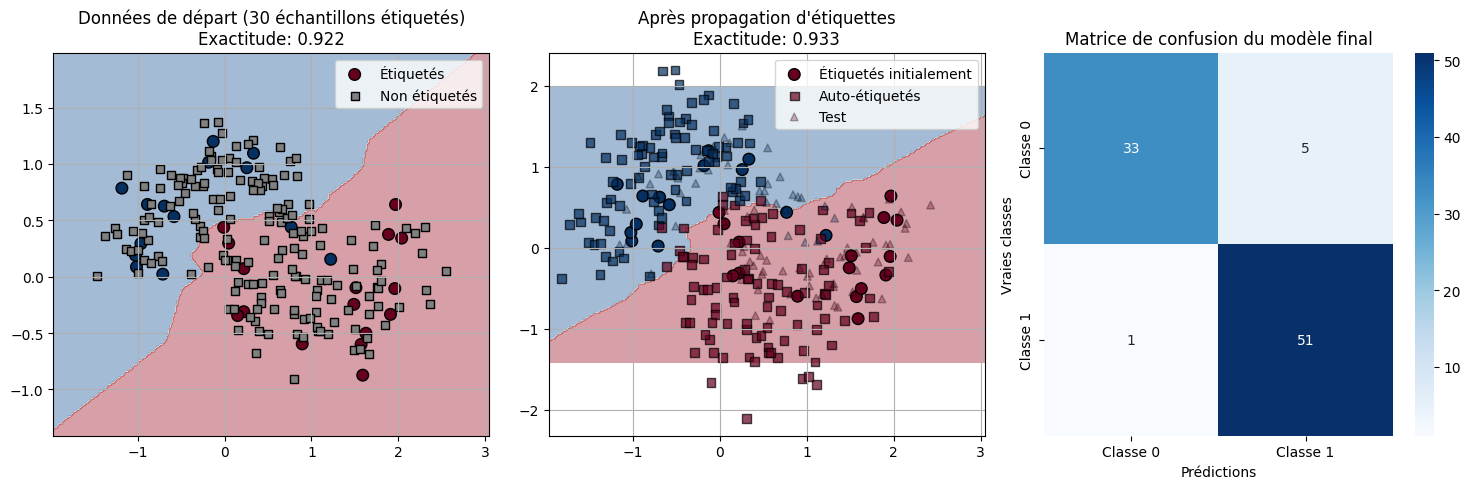

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Génération des données et préparation
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# on fait une séparation
num_labeled = 30
X_labeled, X_unlabeled = X_train[:num_labeled], X_train[num_labeled:]
y_labeled, y_unlabeled_true = y_train[:num_labeled], y_train[num_labeled:]

# Standardisation
scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled)
X_test_scaled = scaler.transform(X_test)

# Calcul de la matrice de similarité
def calculate_similarity(X):
    distances = squareform(pdist(X, 'euclidean'))
    sigma = np.mean(distances)
    return np.exp(-distances**2 / (2 * sigma**2))

# Propagation d'étiquettes
def propagate_labels(X_labeled, y_labeled, X_unlabeled, threshold=0.8, k=5):
    X_all = np.vstack([X_labeled, X_unlabeled])
    n_labeled = X_labeled.shape[0]
    similarity_matrix = calculate_similarity(X_all)

    labels = np.ones(len(X_unlabeled)) * -1
    confidences = np.zeros(len(X_unlabeled))

    for i in range(len(X_unlabeled)):
        similarities = similarity_matrix[n_labeled + i, :n_labeled]
        most_similar = np.argsort(similarities)[-k:]
        high_sim_mask = similarities[most_similar] > threshold
        most_similar = most_similar[high_sim_mask]

        if len(most_similar) > 0:
            similar_labels = y_labeled[most_similar]
            weights = similarities[most_similar]
            votes = np.bincount(similar_labels.astype(int), weights=weights, minlength=2)
            labels[i] = np.argmax(votes)
            confidences[i] = votes[labels[i].astype(int)] / np.sum(votes)

    valid_mask = labels != -1
    return labels, confidences, valid_mask

# Modèle initial pour comparaison
initial_knn = KNeighborsClassifier(n_neighbors=5)
initial_knn.fit(X_labeled_scaled, y_labeled)
initial_preds = initial_knn.predict(X_test_scaled)
initial_accuracy = accuracy_score(y_test, initial_preds)

# Algorithme de propagation
X_current_labeled = X_labeled_scaled.copy()
y_current_labeled = y_labeled.copy()
X_current_unlabeled = X_unlabeled_scaled.copy()
similarity_threshold = 0.8
max_iterations = 10
newly_labeled_points = []
newly_labeled_labels = []

for iteration in range(max_iterations):
    if len(X_current_unlabeled) == 0:
        break

    propagated_labels, confidence, valid_mask = propagate_labels(
        X_current_labeled, y_current_labeled, X_current_unlabeled,
        similarity_threshold, 5
    )

    if np.sum(valid_mask) == 0:
        similarity_threshold *= 0.9
        continue

    newly_labeled_points.append(X_current_unlabeled[valid_mask])
    newly_labeled_labels.append(propagated_labels[valid_mask])

    X_current_labeled = np.vstack([X_current_labeled, X_current_unlabeled[valid_mask]])
    y_current_labeled = np.append(y_current_labeled, propagated_labels[valid_mask])

    X_current_unlabeled = X_current_unlabeled[~valid_mask]

# Modèle final
final_knn = KNeighborsClassifier(n_neighbors=5)
final_knn.fit(X_current_labeled, y_current_labeled)
final_preds = final_knn.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, final_preds)
conf_matrix = confusion_matrix(y_test, final_preds)

# Frontières de décision pour visualisation
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_scaled = scaler.transform(grid_points)

Z_initial = initial_knn.predict(grid_points_scaled).reshape(xx.shape)
Z_final = final_knn.predict(grid_points_scaled).reshape(xx.shape)

plt.figure(figsize=(10, 5))

# 1. Graphique des données de départ
plt.subplot(1, 3, 1)
plt.contourf(xx, yy, Z_initial, alpha=0.4, cmap=plt.cm.RdBu_r)
plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled,
            cmap=plt.cm.RdBu_r, edgecolors='k', s=70, marker='o', label='Étiquetés')
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c='gray',
            edgecolors='k', s=30, marker='s', label='Non étiquetés')
plt.title(f'Données de départ (30 échantillons étiquetés)\nExactitude: {initial_accuracy:.3f}')
plt.legend()
plt.grid(True)

# 2. Graphique final après propagation
plt.subplot(1, 3, 2)
plt.contourf(xx, yy, Z_final, alpha=0.4, cmap=plt.cm.RdBu_r)
plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled,
            cmap=plt.cm.RdBu_r, edgecolors='k', s=70, marker='o', label='Étiquetés initialement')

if len(newly_labeled_points) > 0:
    all_new_X = np.vstack(newly_labeled_points)
    all_new_y = np.hstack(newly_labeled_labels)
    plt.scatter(all_new_X[:, 0], all_new_X[:, 1], c=all_new_y,
                cmap=plt.cm.RdBu_r, edgecolors='k', s=40, marker='s', alpha=0.7, label='Auto-étiquetés')

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test,
            cmap=plt.cm.RdBu_r, edgecolors='k', s=30, marker='^', alpha=0.3, label='Test')
plt.title(f'Après propagation d\'étiquettes\nExactitude: {final_accuracy:.3f}')
plt.legend()
plt.grid(True)

# 3. Matrice de confusion
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion du modèle final")

plt.tight_layout()
plt.savefig('simplified_propagation_results.png', dpi=300, bbox_inches='tight')
plt.show()